In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data = pd.read_csv('ethereum_daily_data_2018_2024.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.head()

,Open,High,Low,Close,Volume
time,,,,,
2018-01-01,741.69,766.49,718.90,757.22,910875.63
2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2018-01-03,861.97,951.70,847.90,941.10,871172.13
2018-01-04,941.00,997.44,901.03,944.83,822844.78
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53


In [ ]:
y = data['Close'].reset_index(drop=True)
y.head()

,Close
0,757.22
1,861.97
2,941.10
3,944.83
4,963.88


In [ ]:
train_len = 400
test_len = 100
n = train_len + test_len
preds = []
lower = []
upper = []
truth = []
alpha = 0.05
for t in range(train_len, n):
    history = y.iloc[:t]
    model = ARIMA(history, order=(2,2,1), trend='n').fit()
    fc = model.get_forecast(steps=1)
    mean = float(fc.predicted_mean.iloc[0])
    ci = fc.conf_int(alpha=alpha).iloc[0]
    lower_i, upper_i = float(ci.iloc[0]), float(ci.iloc[1])
    preds.append(mean)
    lower.append(lower_i)
    upper.append(upper_i)
    truth.append(float(y.iloc[t]))

In [ ]:
mae = mean_absolute_error(truth, preds)
rmse = np.sqrt(mean_squared_error(truth, preds))
mape = np.mean(np.abs((np.array(truth) - np.array(preds)) / np.clip(np.array(truth), 1e-10, None))) * 100
coverage = np.mean([(truth[i] >= lower[i]) and (truth[i] <= upper[i]) for i in range(len(truth))])

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"CI 95% empirical coverage: {coverage*100:.1f}%")

MAE: 4.55
RMSE: 6.99
MAPE: 2.97%
CI 95% empirical coverage: 100.0%


In [ ]:
test_index = data.index[train_len:n]
df_res = pd.DataFrame({
    'truth': truth,
    'pred': preds,
    'lower': lower,
    'upper': upper
}, index=test_index)

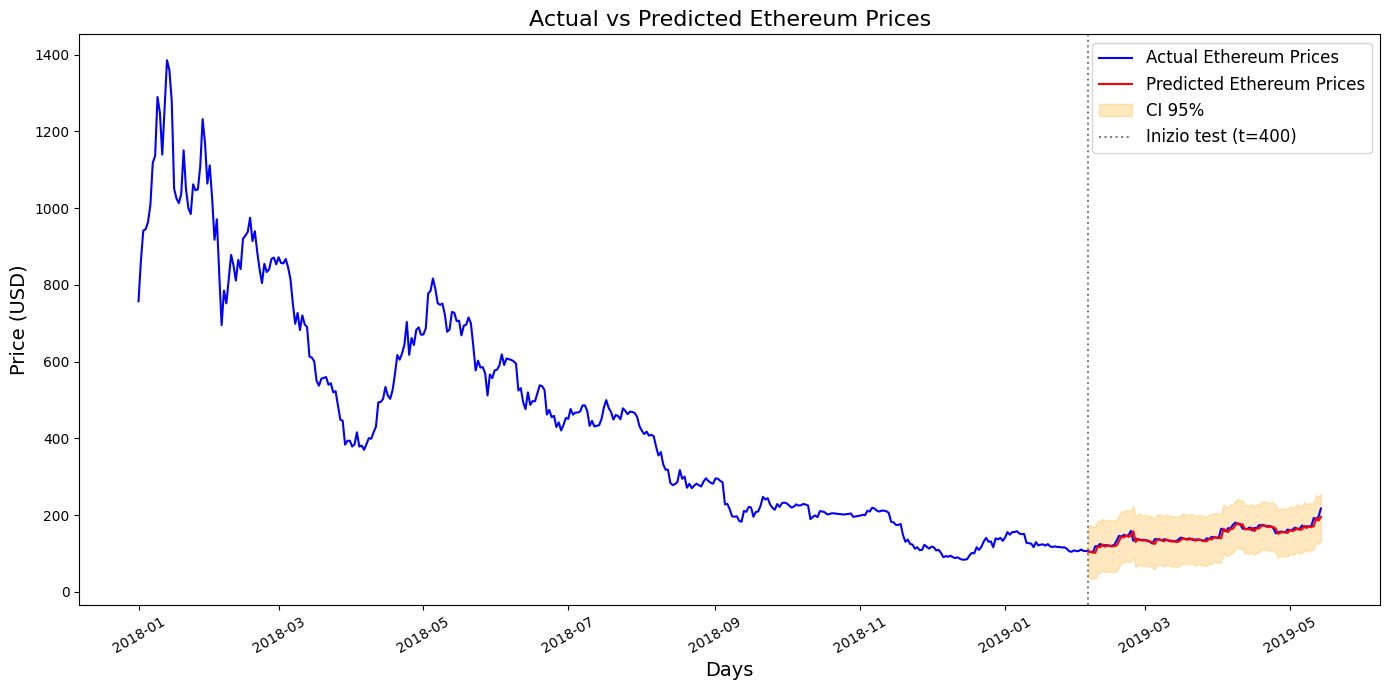

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(data.index[:n], y.iloc[:n], label='Actual Ethereum Prices', color='blue')

plt.plot(df_res.index, df_res['pred'], label='Predicted Ethereum Prices', color='red')

plt.fill_between(df_res.index, df_res['lower'], df_res['upper'], color='orange', alpha=0.25, label='CI 95%')

plt.axvline(x=data.index[train_len], color='gray', linestyle=':', label='Inizio test (t=400)')

plt.title('Actual vs Predicted Ethereum Prices', fontsize = 16)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Price (USD)', fontsize = 14)
plt.legend(fontsize = 12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

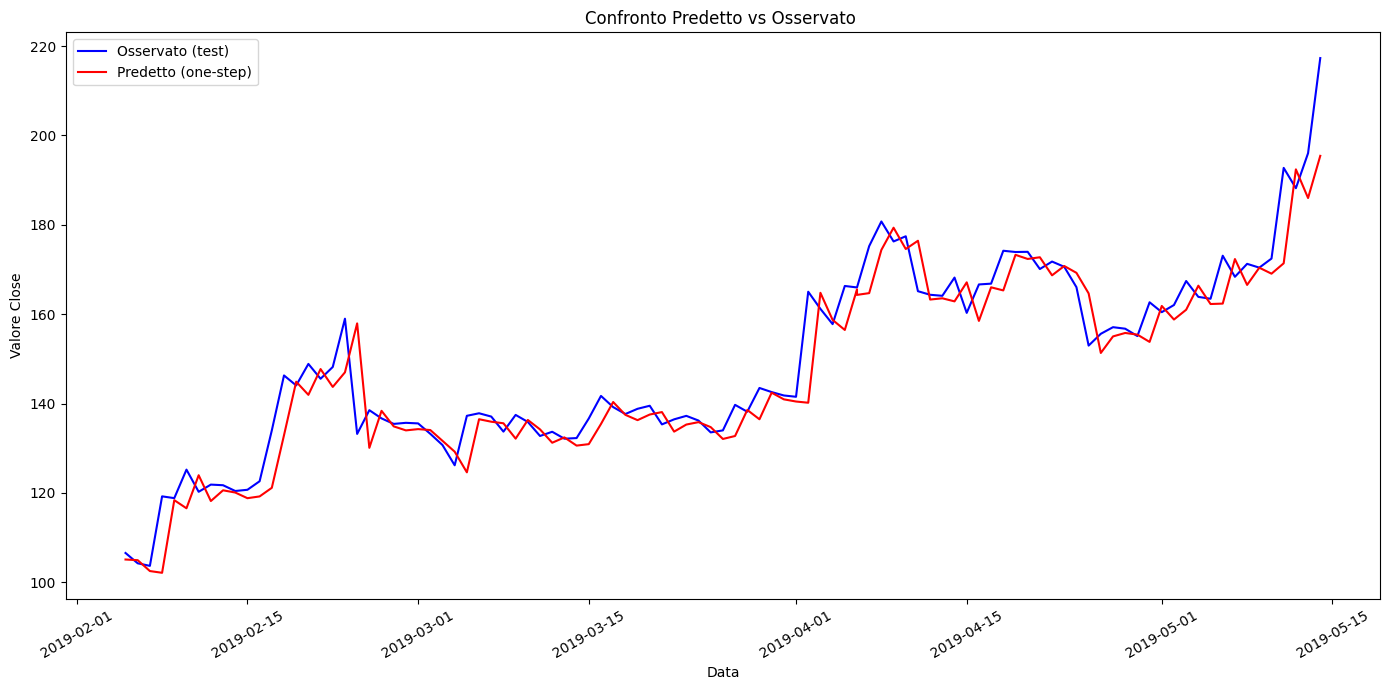

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(df_res.index, df_res['truth'], label='Osservato (test)', color='blue')
plt.plot(df_res.index, df_res['pred'], label='Predetto (one-step)', color='red')

plt.title('Confronto Predetto vs Osservato ')
plt.xlabel('Data' if isinstance(data.index, pd.DatetimeIndex) else 'Indice temporale')
plt.ylabel('Valore Close')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()